In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join(
    '/Users',
    'chair',
    'Documents',
    'Academia',
    'SuperRes',
    'Biteen_colab',
    'Mispolarization',
    'python',
    ))
sys.path.append(module_path)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

## Get physical constants from Scipy
import scipy.constants as con
## Some useful numerical constants
hbar = con.physical_constants['Planck constant over 2 pi in eV s'][0]
c = con.physical_constants['speed of light in vacuum'][0]*1e2 #cm/m
kb = con.physical_constants['Boltzmann constant in eV/K'][0]

import scipy.integrate as int

import scipy.io as sio

import scipy.optimize as opt

import scipy.interpolate as interp

from misloc_mispol_package.parameterize import displaced_osc_model as dom


In [2]:
## This needs to be in a seperate cell from the imports
## Matplotlib settings
## inspired by http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'magma',
    'axes.grid': False,
    'figure.dpi': 150,  # to adjust notebook inline plot size
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 8, # was 10
    'legend.fontsize': 8, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': False,
#     'figure.figsize': [3.5, 2.625], # 4 x 3
#     'figure.figsize': [4, 3], # 4 x 3
    'figure.figsize': [4*1.125, 3*1.125], # 4x3, full slide in keynote
    'font.family': 'serif',
    'figure.max_open_warning':100
}
mpl.rcParams.update(params)


In [3]:
lambda_g = [
    0,
    0,
    0.500141 - .5, ## to account for H_0 
    - 0.0456629,
    0.00243193,
    - 0.000095158,
    2.99251*1e-6,
    - 7.93207*1e-8,
    + 1.82486*1e-9,
    - 3.71702*1e-11,
    6.80059*1e-13,
    - 1.13*1e-14,
    + 1.72033*1e-16,
    ]

## Unitless displacement of excited state vibrational potential
d = 1.6

## Build excited state lambdas from ground state and displacement
lambda_e = dom.displaced_lambdas(lambda_g, d=d)

## Number of oscillator states used for representation of general 
## potential energy eigenstates
basis_size = 20
## Energy spacing of unperterbed vibration
hbarw0 = 1
hbar_gamma = .18

## Assign the temperature
T = .3*hbarw0/kb

In [4]:
def mag_norm(y_values):
    max=np.max(y_values)
    
    return y_values/max

# def norm(y_values):
#     """ Magnitude normalize data. """
#     return y_values/y_values.max()


# General Morse potential excited state

In [5]:
def lambda_generator_Morse(a, D):
    """ This is a function that returns the lambda prefactors for a Morse
        Potential expanded to 12th order. 
        
        Returns:
        -------
            lambdas: an array of perterbed polynomial prefactors determined from Mathematica
        """
    lambdas = np.array([
        0, 
        0,
        ## Make sure to subtract .5 from harmonic term to accound for the 
        ## unperterbed potential 
        a**2. * D - 0.5,
        -a**3. * D,
        (7/12) * a**4 * D,
        (-1/4) * a**5 * D,
        (31/360) * a**6 * D,
        (-1/40) * a**7 * D,
        (127/20160) * a**8 * D,
        (-17/12096) * a**9 * D,
        (73/259200) * a**10 * D,
        (-31/604800) * a**11 * D,
        (2047/239500800) * a**12 * D,
        ])

    
    return lambdas

In [6]:
D = 60
alpha = 0.0913
lambda_generator_Morse(alpha, D)

array([ 0.00000000e+00,  0.00000000e+00,  1.41400000e-04, -4.56629098e-02,
        2.43193047e-03, -9.51579652e-05,  2.99250654e-06, -7.93207299e-08,
        1.82486467e-09, -3.71702422e-11,  6.80059464e-13, -1.13000331e-14,
        1.72032878e-16])

In [7]:
## Energy spacing of unperterbed vibration
hbarw0_mor = 1
# D = hbarw0_mor
D = 60
alpha = 0.0913
gamma=.18/hbar

mor_lam_g = lambda_generator_Morse(alpha, D)

## Build excited state lambdas from ground state and displacement
mor_lam_e = dom.displaced_lambdas(mor_lam_g, d=1.6)

## Assign the temperature
T_mor = 294

## Number of oscillator states used for representation of general 
## potential energy eigenstates
basis_size = 20
## Define Vibrational Hamiltonians in units of energy (by multiplying by 
## the unperturbed vibrational energy spacing).
## -----

Test to see that the surface looks right

In [8]:
pot_xs = np.linspace(-7, 10, 100)
Vg_of_x = dom.poly_from_lambdas(pot_xs, mor_lam_g)
Ve_of_x = dom.poly_from_lambdas(pot_xs, mor_lam_e)


(0, 50)

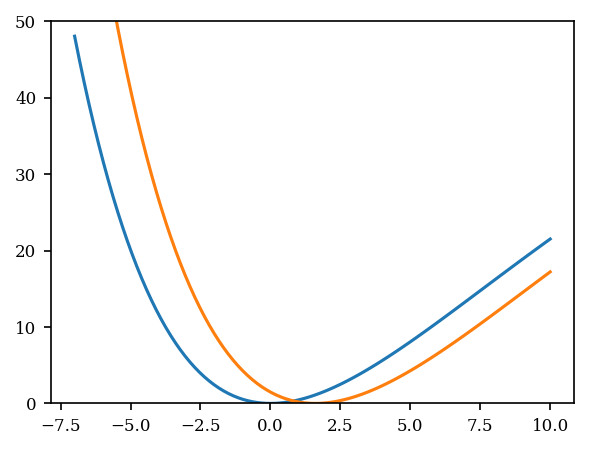

In [9]:
plt.plot(pot_xs, Vg_of_x)
plt.plot(pot_xs, Ve_of_x)
plt.ylim([0,50])

## Test the multimode class

In [11]:
mm_lam_g = np.vstack((mor_lam_g, np.zeros(13)))
mm_lam_e = np.vstack((mor_lam_e, dom.displaced_lambdas(np.zeros(13), d)))

multimode_test_inst = dom.multi_mode_anharmonic_emission(
    mm_lam_g,
    mm_lam_e,
    basis_size,
    hbar_omega_0=np.array([hbarw0_mor, hbarw0_mor/5]),
    hbar_gamma=hbar*gamma,
    T=T_mor,
    integration_t_max=20,
    integration_t_points=600,
    A_mat_order=7,
    )
    
hbar_omegas_mor = np.linspace(-5, 10, 300)
mm_lineshape = multimode_test_inst.emission_lineshape(
    hbar_omegas_mor)

In [12]:
mm_lineshape_m0 = multimode_test_inst.emission_lineshape(
    hbar_omegas_mor,
    isolate_mode=0)
mm_lineshape_m1 = multimode_test_inst.emission_lineshape(
    hbar_omegas_mor,
    isolate_mode=1)

Text(0, 0.5, 'Emission Lineshape [a.u.]')

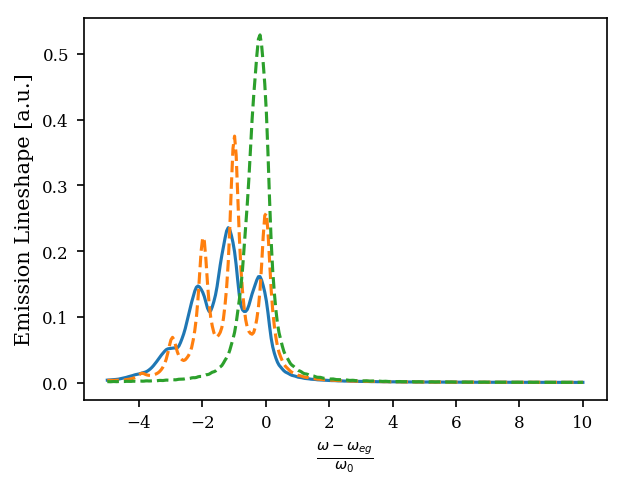

In [13]:
plt.plot(hbar_omegas_mor, mm_lineshape)
plt.plot(hbar_omegas_mor, mm_lineshape_m0, ls='--')
plt.plot(hbar_omegas_mor, mm_lineshape_m1, ls='--')
plt.xlabel(r'$\frac{\omega - \omega_{eg}}{\omega_0}$', fontsize=10)
plt.ylabel(r'Emission Lineshape [a.u.]', fontsize=10)

In [14]:
mm_lam_g = np.vstack((mor_lam_g, np.zeros(13)))
mm_lam_e = np.vstack((mor_lam_e, dom.displaced_lambdas(np.zeros(13), d/10)))

multimode_test_inst = dom.multi_mode_anharmonic_emission(
    mm_lam_g,
    mm_lam_e,
    basis_size,
    hbar_omega_0=np.array([hbarw0_mor, hbarw0_mor/5]),
    hbar_gamma=hbar*gamma,
    T=T_mor,
    integration_t_max=20,
    integration_t_points=600,
    A_mat_order=7,
    )
    
hbar_omegas_mor = np.linspace(-5, 10, 300)
mm_lineshape = multimode_test_inst.emission_lineshape(
    hbar_omegas_mor)

In [15]:
mm_lineshape_m0 = multimode_test_inst.emission_lineshape(
    hbar_omegas_mor,
    isolate_mode=0)
mm_lineshape_m1 = multimode_test_inst.emission_lineshape(
    hbar_omegas_mor,
    isolate_mode=1)

Text(0, 0.5, 'Emission Lineshape [a.u.]')

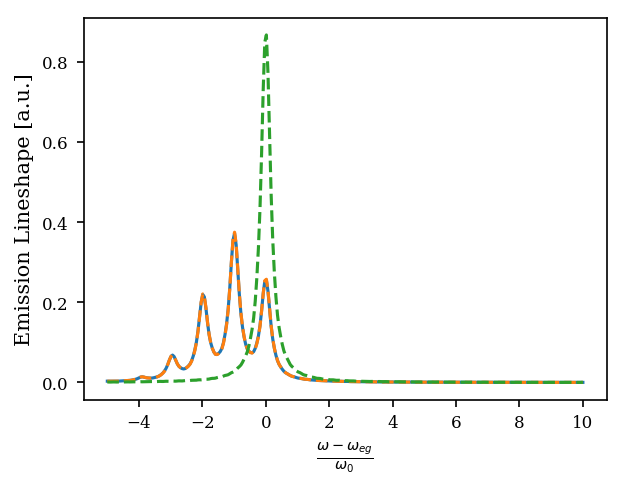

In [16]:
plt.plot(hbar_omegas_mor, mm_lineshape)
plt.plot(hbar_omegas_mor, mm_lineshape_m0, ls='--')
plt.plot(hbar_omegas_mor, mm_lineshape_m1, ls='--')
plt.xlabel(r'$\frac{\omega - \omega_{eg}}{\omega_0}$', fontsize=10)
plt.ylabel(r'Emission Lineshape [a.u.]', fontsize=10)

In [17]:
mm_lam_g = np.vstack((mor_lam_g, np.zeros(13)))
mm_lam_e = np.vstack((mor_lam_e, dom.displaced_lambdas(np.zeros(13), d/10)))


hbarw0_mor=2

multimode_test_inst = dom.multi_mode_anharmonic_emission(
    mm_lam_g,
    mm_lam_e,
    basis_size,
    hbar_omega_0=np.array([hbarw0_mor, hbarw0_mor/5]),
    hbar_gamma=hbar*gamma,
    T=T_mor,
    integration_t_max=20,
    integration_t_points=600,
    A_mat_order=7,
    )
    
hbar_omegas_mor = np.linspace(-5, 10, 300)
mm_lineshape = multimode_test_inst.emission_lineshape(
    hbar_omegas_mor)

In [18]:
mm_lineshape_m0 = multimode_test_inst.emission_lineshape(
    hbar_omegas_mor,
    isolate_mode=0)
mm_lineshape_m1 = multimode_test_inst.emission_lineshape(
    hbar_omegas_mor,
    isolate_mode=1)

Text(0, 0.5, 'Emission Lineshape [a.u.]')

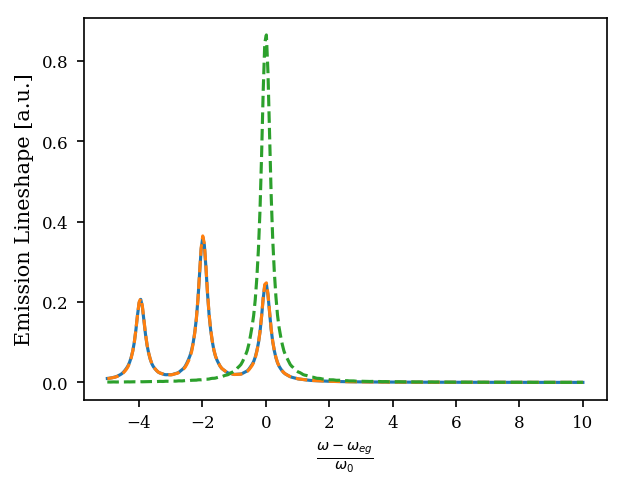

In [19]:
plt.plot(hbar_omegas_mor, mm_lineshape)
plt.plot(hbar_omegas_mor, mm_lineshape_m0, ls='--')
plt.plot(hbar_omegas_mor, mm_lineshape_m1, ls='--')
plt.xlabel(r'$\frac{\omega - \omega_{eg}}{\omega_0}$', fontsize=10)
plt.ylabel(r'Emission Lineshape [a.u.]', fontsize=10)

In [20]:
multimode_test_inst.hbar_omega_eg

array([2.20739264, 0.00512   ])